In [1]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

#import genutils
import os
import sys
import numpy as np
import re
import scipy 
import matplotlib.patches as patches
import glob

In [2]:
####################################################################################
#Defining variables based on script inputs
directory = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/GenotypeProportions/'
samplefile = directory + '89sample_ancient_Freedman_Lcu2_all_GF_filter_geno0_LabelFile.txt'
propRefAlleleCutoff = float(0.95)
propNonRefAlleleCutoff = float(0.05)


In [3]:
######################################################   
#Opening a summary output file
summaryfile = directory + 'SummaryTable_TotalWildProportions_AllWindows.txt'
summaryFile = open(summaryfile, 'w')
headerLine = 'Window\tProportionCutoff\tWildSamples\tNumberAncientDogs\tNumberBreeds\tNumberVillageDogs\tNumberWolves\tNumberOutgroups\tProp.Dogs\tProp.VillageDogs\tSNPCount\n'
summaryFile.write(headerLine)

summarytable = directory + 'TableOfAllWindows.txt'
summaryTable = open(summarytable, 'w')

In [4]:
######################################################
def write_header(outFile, FST):#file header line
    headerLine = 'SampleID\t0/0\tProp0/0\t0/1\tProp0/1\t1/1\tProp1/1\t%s_RefAlleleCount\t%s_NonRefAlleleCount\n' %(FST,FST)
    outFile.write(headerLine) #writing header line to outfile
######################################################   
def process_samples(samplefile, genoArray):
    #print 'Reading in sample IDs from sample file: ', args.sample_file
    f=open(samplefile,'r')
    sampleCount = 0
    for line in f:
        sampleID = line.rstrip().split('\t')[0]
        line = line.rstrip()
        line = line.split()
        canineType = line[2] #Breed, VillageDog, Wolf, Outgroup, etc.
        sample_array.append(sampleID)
        sampleDict[sampleID] = canineType
        sampleCount += 1
        
        #save sample to dictionary:
        genoArray[sampleID] = []
        
    return sampleDict, genoArray
######################################################   
def setVariables(line):
    numWolves = 0
    numBreeds = 0
    numVillageDogs = 0
    numOutgroups = 0
    numAncient = 0
    numFSTVillageDogs = 0
    return (numWolves, numBreeds, numVillageDogs, numOutgroups, numAncient, numFSTVillageDogs)
######################################################   
#obtain reference allele proportion for a given cdr region
def get_ref_prop(dog,data):
    for w in data[dog]:
        ref_prop = float(w)
        return ref_prop
######################################################   


In [5]:
genoArray = {}
#print 'Reading in sample IDs from sample file: ', args.sample_file
f=open(samplefile,'r')
sampleCount = 0
for line in f:
    line = line.rstrip()
    line = line.split()
    sample = line[0]
    genoArray[sample] = []

In [6]:
path = '/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/results/No_MAF_Filtration/'
#filestart = 'CDRExtracted_89sample_ancient_Freedman_Lcu2_all.bim_'
filestart = 'CDRExtracted_89sample_ancient_Freedman_Lcu2_all_geno0_'
cdrList = []

######################################################
for file in glob.glob(path + '*geno0_*eigenstratgeno'): #May need to change this to whatever consistent naming you have for all of your bed (PLINK) files (i.e. CDR, FST, filt, etc.)
    filename=file.replace(".eigenstratgeno","")
    CDR=filename.replace(path + filestart,"")
    cdrList.append(CDR)
    inFile = open(file, 'r')
    
    #Creating output file from FST and filename 
    outfile = directory + 'TotalGenotypeProportions_' + CDR + '.txt'
    outFile = open(outfile, 'w')
    write_header(outFile, CDR) #writes header line to outfile defined above
    
    array = []     #Generate array to store all data:
    sample_array = [] #array of sample IDs
    sampleDict = {}
    
    genoList = [] #array of genotypes
    snpCount = 0 #count of SNPs per FST window
        
    for line in inFile:
        line = line.rstrip()
        snpCount += 1
        sampleCount = len(line) #Number of individuals in the analysis = the # of characters in the line
        
        genoList = list(line)
        genoList = ''.join(genoList)
        array.append(map(int,genoList))
    
    print 'Number of SNPs in %s region: %i' % (CDR,snpCount)
    
    #print 'Generated transposed matrix for %i SNPs' % (snpCount)
    matrix=np.array(array) #turns array into a numpy array called 'matrix'
    new_matrix=matrix.T #transposes the original 'matrix' into 'new_matrix' for readability
    
    process_samples(samplefile, genoArray)
    
    new_array = np.array(new_matrix)
    wildArray = []
    nonWildArray = []
    numWolves, numBreeds, numVillageDogs, numOutgroups, numAncient, numFSTVillageDogs  = setVariables(line)

    for i in range(sampleCount):
        missingCount = (new_array[i] == 9).sum() * 2
        #Counting genotypes 0/0, 0/1, 1/1
        sum0 = (new_array[i] == 0).sum()
        prop0 = float(sum0)/snpCount
        sum1 = (new_array[i] == 1).sum()
        prop1 = float(sum1) / snpCount
        sum2 = (new_array[i] == 2).sum()
        prop2 = float(sum2)/ snpCount
        sample = sample_array[i]
        
        #Counting alleles
        ref = int(2*sum0 + sum1)
        nonRef = int(2*sum2 + sum1)
        alleleTotal = ref + nonRef
        refProp = float(ref)/alleleTotal
        nonrefProp = float(nonRef)/alleleTotal

        nonRefProp = float(nonRef)/alleleTotal
        #print ref, nonRef, alleleTotal, missingCount
        if missingCount + alleleTotal != snpCount*2: #check to make sure everything is getting processed corrrectly
            print 'ERROR: Missing sites + sites with data do not add up to total number of SNPs'
        outFile.write('%s\t%i\t%f\t%i\t%f\t%i\t%f\t%f\t%f\n' % (sample, sum0, prop0, sum1, prop1,sum2,prop2, refProp, nonRefProp))
        
        
        if refProp < propRefAlleleCutoff: #Proportion of alleles that are reference (2*0/0 and 1*01)
            wildArray.append(sample)
            if sampleDict[sample] == 'Wolf':
                numWolves += 1
            if sampleDict[sample] == 'Breed':
                numBreeds += 1
            if sampleDict[sample] == 'VillageDog': #All village dogs
                numVillageDogs += 1
            if sampleDict[sample] == 'VillageDog' and 'ID91' not in sample and 'ID60' not in sample: #does not include the village dogs we excluded in our FST analysis due to wolf admixture
                numFSTVillageDogs += 1
            if sampleDict[sample] == 'AncientDog':
                numAncient += 1
            if sampleDict[sample] == 'Coyote' or sampleDict[sample] == 'Jackal' or sampleDict[sample] == 'Fox':
                numOutgroups += 1
        """
        if nonrefProp > propNonRefAlleleCutoff: #Proportion of alleles that are non-reference (2*1/1 and 1*0/1)
            nonWildArray.append(sample)
            if sampleDict[sample] == 'Wolf':
                numWolves += 1
            if sampleDict[sample] == 'Breed':
                numBreeds += 1
            if sampleDict[sample] == 'VillageDog': #All village dogs
                numVillageDogs += 1
            if sampleDict[sample] == 'VillageDog' and 'ID91' not in sample and 'ID60' not in sample: #does not include the village dogs we excluded in our FST analysis due to wolf admixture
                numFSTVillageDogs += 1
            if sampleDict[sample] == 'AncientDog':
                numAncient += 1
            if sampleDict[sample] == 'Coyote' or sampleDict[sample] == 'Jackal' or sampleDict[sample] == 'Fox':
                numOutgroups += 1
        """
    numDogs = numBreeds + numVillageDogs + numAncient
    propDogs = float(numDogs)/80 #There are 80 dogs in the sample set
    propFSTVillageDogs = float(numFSTVillageDogs)/43 #number of village dogs 
    
    #wildIDs = ",".join(wildArray)
    #numWild = len(wildArray)
    nonWildIDs = ",".join(nonWildArray)
    numNonWild = len(nonWildArray)
    #summaryFile.write('%s\t%f\t%s\t%s\t%s\t%s\t%s\t%s\t%f\t%f\t%i\n' % (FST,propRefAlleleCutoff,wildIDs, numAncient, numBreeds, numVillageDogs, numWolves, numOutgroups, propDogs, propFSTVillageDogs, snpCount))
    #print '%s\t%f\t%s\t%s\t%s\t%s\t%s\t%s\t%f\t%f\t%i\n' % (FST,propRefAlleleCutoff,nonWildIDs, numAncient, numBreeds, numVillageDogs, numWolves, numOutgroups,propDogs,propFSTVillageDogs,snpCount)
    outFile.close()

Number of SNPs in CDR13 region: 1758
Number of SNPs in CDR16 region: 151
Number of SNPs in CDR22 region: 274
Number of SNPs in CDR17 region: 151
Number of SNPs in CDR6 region: 12
Number of SNPs in CDR23 region: 976
Number of SNPs in CDR1 region: 880
Number of SNPs in CDR19 region: 281
Number of SNPs in CDR10 region: 174
Number of SNPs in CDR2 region: 500
Number of SNPs in CDR28 region: 181
Number of SNPs in CDR21 region: 188
Number of SNPs in CDR20 region: 590
Number of SNPs in CDR3 region: 191
Number of SNPs in CDR25 region: 1811
Number of SNPs in CDR18 region: 278
Number of SNPs in CDR24 region: 203
Number of SNPs in CDR8 region: 687
Number of SNPs in CDR9 region: 251
Number of SNPs in CDR11 region: 461
Number of SNPs in CDR27 region: 307
Number of SNPs in CDR29 region: 208
Number of SNPs in CDR30 region: 184
Number of SNPs in CDR14 region: 242
Number of SNPs in CDR7 region: 195
Number of SNPs in CDR12 region: 169
Number of SNPs in CDR5 region: 597
Number of SNPs in CDR15 region: 293

In [8]:
villageDogCount = 0
ancientDogCount = 0
for i in sampleDict:
    if 'VillageDog' in sampleDict[i]:
        villageDogCount += 1
    if 'Ancient' in sampleDict[i]:
        ancientDogCount += 1
print 'Number of village dogs in our analysis: ', villageDogCount 
print 'Number of ancient dog samples in our analysis: ', ancientDogCount

Number of village dogs in our analysis:  45
Number of ancient dog samples in our analysis:  3


In [9]:
#Determining the order I want to plot the dogs in for the bar plot for reference allele proportions
RDplotOrder = []

#inFile = open('sample-plot-order.txt')
inFile = open('/home/ampend/kidd-lab/ampend-projects/Angela/amy2b/input/' + 'rd-sample-plot-order-2.txt')
for line in inFile:
    line = line.rstrip()
    line = line.split('\t')
    if 'Lcu' in line[0]:
        continue
    if 'ysb' in line[0]:
        continue
    RDplotOrder.append([line[0],line[1],line[2],line[3],line[4]])
inFile.close()
print 'Number of samples to plot:', len(RDplotOrder)

Number of samples to plot: 98


In [10]:
#Determining the order I want to plot the dogs in for the bar plot for reference allele proportions
fstDogs = []
notFSTSample = ['Lcu','ysb','mxb']

inFile = open('/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/GenotypeProportions/input/GenomeSampleInfoTable-VillageGreyWolves_lowAdmix.txt', 'r')
for line in inFile:
    line = line.rstrip()
    line = line.split('\t')
    sampleID = line[0]
    if 'sampleName' in sampleID: #skips header
        continue
    if sampleID in notFSTSample:
        continue
    if 'pen' in sampleID:
        fstDogs.append('IBW') #replaces penelope with IBW
        continue
    fstDogs.append(line[0])
    #fstDogs.append([line[0],line[1],line[2]])
inFile.close()
print 'Samples that went into Fst analysis: ', len(fstDogs)

Samples that went into Fst analysis:  53


In [11]:
###################################################################
from collections import OrderedDict
refDict = OrderedDict()

f=open(samplefile,'r')
refDict['ID'] = []
refDict['SampleID'] = []
refDict['CanineType'] = []
for line in f:
    sampleID = line.rstrip().split('\t')[0]
    line = line.rstrip()
    line = line.split()
    canineType = line[2] #Breed, VillageDog, Wolf, Outgroup, etc.
    refDict['ID'].append(line[0])
    refDict['SampleID'].append(line[1])
    refDict['CanineType'].append(canineType)

search = directory + 'TotalGenotypeProportions_CDR*.txt'
for file in glob.glob(search):
    FST=file.replace(".txt","")
    FST=FST.replace(directory,"")
    FST=FST.replace('TotalGenotypeProportions_',"")
    
    infile = open(file, 'r')
    refDict[FST] = []
        
    for line in infile:
        line = line.rstrip()
        line = line.split()
        if 'SampleID' in line[0]:
            continue
        refDict[FST].append(line[7])


refAlleleCountfile = directory + 'NonReferenceAlelleCounts_AllWindows.txt'
refAlleleCountFile = open(refAlleleCountfile, 'w')

outArray = []
for key in refDict.keys():
    refAlleleCountFile.write('%s\t'%key)
    #for FST in refDict[key]:
    outLine = "\t".join(refDict[key])
    refAlleleCountFile.write('%s\n'%outLine)
    outArray.append(refDict[key])
matrix=np.array(outArray) #turns array into a numpy array called 'matrix'
new_matrix=matrix.T

#Invert of previous outfile
refAlleleCountfile_inv = directory + 'NonReferenceAlelleCounts_AllWindows_Inverted.txt'
refAlleleCountFile_inv = open(refAlleleCountfile_inv, 'w')

refAlleleCountFile_inv.write('SampleID\tSampleDescription\t')
for i in cdrList:
    refAlleleCountFile_inv.write('%s\t'% (i))
refAlleleCountFile_inv.write('\n')



In [12]:
propData = {}
infile = open('/home/ampend/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Haplotype_Analysis/GenotypeProportions/ReferenceAlelleCounts_AllWindows.txt','r')
for line in infile:
    line = line.rstrip().split('\t')
    if 'ID' in line and 'SampleID' not in line:
        dogs = line[1:]
    if 'CDR' in line[0]:
        CDR = line[0]
        propData[CDR] = line[1:]
print 'Number of CDRs with proportion data: ', len(propData)

Number of CDRs with proportion data:  30


In [13]:
def find_dogwolf_average(RDplotOrder,data):  
    wolfAverage,dogAverage,villageDogAverage,breedDogAverage,ancientDogAverage = [],[],[],[],[]
    for i in range(len(RDplotOrder)):
        canineType, sample = RDplotOrder[i][2],RDplotOrder[i][0]
        prop = (1-get_ref_prop(RDplotOrder[i][0],data))
        if canineType == 'Wolf' and sample in fstDogs:
            wolfAverage.append(prop)
        if canineType == 'VillageDog':
            if sample in fstDogs:
                dogAverage.append(prop)             
            villageDogAverage.append(prop)
        if canineType == 'Breed':
            breedDogAverage.append(prop)
            dogAverage.append(prop)
        if canineType == 'AncientDog':
            ancientDogAverage.append(prop)
            dogAverage.append(prop)
    dogSD = np.std(dogAverage)
    wolfMean,dogMean,villageMean,breedMean,ancientMean = np.mean(wolfAverage), np.mean(dogAverage), np.mean(villageDogAverage), np.mean(breedDogAverage), np.mean(ancientDogAverage)
    return wolfMean,dogMean,villageMean,breedMean,ancientMean,dogSD
################################################################################
def find_outlier_dogs(CDRAverages,RDplotOrder):
    outlierDogCount = 0
    outlierSampleList = []
    for i in range(len(RDplotOrder)):
        canineType, sample = RDplotOrder[i][2],RDplotOrder[i][0]
        if canineType == 'VillageDog' or canineType == 'Breed' or canineType == 'AncientDog':
            prop = (1-get_ref_prop(RDplotOrder[i][0],data))
            if prop >= CDRAverages[CDR][1]:
                print CDRAverages[CDR][1],prop,sample
                outlierSampleList.append(sample)
                outlierDogCount += 1
    return outlierSampleList, outlierDogCount
################################################################################
def analyze_ancients(CDRAverages,RDplotOrder,CDR):
    hxh,ctc,ngd = True, True, True
    ancients = ['HXH','CTC','NewGrange']
    for i in range(len(RDplotOrder)):
        sample = RDplotOrder[i][0]
        prop = (1-get_ref_prop(RDplotOrder[i][0],data))
        vdogSD = float(CDRAverages[CDR][6])
        vdogMean=float(CDRAverages[CDR][2])
        cutoff = vdogMean+(2*vdogSD)
        if prop > cutoff:
        #if prop > CDRAverages[CDR][2]:
            if sample in ancients:
                print 'Ancient sample FAIL: %s - %f   cutoff - %f' % (sample, prop, cutoff)
    return hxh,ctc,ngd
################################################################################
def determine_pass_fail_sampled():
    for CDR in propData:
        data = {}
        print CDR
        for i in range(0,len(propData[CDR])):
            dog = dogs[i]
            data[dog] = [propData[CDR][i]]
        #START
        alldogs,dogCount = 0, 0 
        allwolves,wolfCount = 0, 0
        for i in range(len(RDplotOrder)):
            canineType, sample = RDplotOrder[i][2],RDplotOrder[i][0]
            if sample not in fstDogs:
                continue
            prop = (1-get_ref_prop(RDplotOrder[i][0],data))
            if 'VillageDog' == canineType:
                alldogs += 1
                if prop > 0.05:
                    dogCount += 1 
            if 'Wolf' == canineType:
                allwolves += 1
                if prop < 0.05:
                    wolfCount += 1
        print alldogs,allwolves
        propDogFail = float(dogCount)/alldogs
        propWolfFail = float(wolfCount)/allwolves
################################################################################


In [19]:
#find wolf average non-ref allele freq
CDRAverages = {}
CDRAverages['header'] = ['CDRID','WolfMean','DogMean','VillageDogMean','BreedMean','AncientMean']
for CDR in propData:
    data = {}
    print CDR
    for i in range(0,len(propData[CDR])):
        dog = dogs[i]
        data[dog] = [propData[CDR][i]]
    wolfMean,dogMean,villageMean,breedMean,ancientMean,dogSD = find_dogwolf_average(RDplotOrder,data)
    CDRAverages[CDR] = [CDR,wolfMean,dogMean,villageMean,breedMean,ancientMean,dogSD]
    outlierSampleList, outlierDogCount = find_outlier_dogs(CDRAverages,RDplotOrder)
    print 'Outlier count:', outlierDogCount
    hxh,ctc,ngd=analyze_ancients(CDRAverages,RDplotOrder,CDR)
    #print 'Ancients: HXH = %s\tCTC = %s\tNGD = %s' % (hxh,ctc,ngd)
    
    print '##################'


CDR9
Outlier count: 0
##################
CDR8
0.402393555556 0.425036 Dingo
Outlier count: 1
##################
CDR3
0.151541444444 0.164921 NewGrange
0.151541444444 0.17801 PT49
0.151541444444 0.162304 ID125
0.151541444444 0.162304 ID60
0.151541444444 0.17801 1756
0.151541444444 0.162304 Basenji
Outlier count: 6
Ancient sample FAIL: NewGrange - 0.164921   cutoff - 0.113387
##################
CDR2
Outlier count: 0
Ancient sample FAIL: CTC - 0.130000   cutoff - 0.090385
##################
CDR1
0.316603444444 0.393182 Dog02
Outlier count: 1
##################
CDR7
Outlier count: 0
##################
CDR6
0.115740555556 0.125 HXH
0.115740555556 0.125 NA63
0.115740555556 0.125 NA8
0.115740555556 0.166667 16145
0.115740555556 0.166667 tpw
0.115740555556 0.166667 wpw
0.115740555556 0.125 4669
Outlier count: 7
Ancient sample FAIL: HXH - 0.125000   cutoff - 0.122266
##################
CDR5
0.299553444444 0.309045 6610
Outlier count: 1
##################
CDR4
Outlier count: 0
Ancient sample FAI

In [45]:
outfile = open(directory + 'NonRefProp_Averages_PerCDR.txt','w')
for i in CDRAverages:
    print ('\t'.join(map(str,CDRAverages[i])))
    outfile.write('\t'.join(map(str,CDRAverages[i])))

CDRID	WolfMean	DogMean	VillageDogMean	BreedMean	AncientMean
CDR9	0.257414666667	0.0614211025641	0.0629925777778	0.05882734375	0.061753	0.0243040554876
CDR8	0.402393555556	0.0611913717949	0.0467572222222	0.0693686875	0.149684666667	0.0820483899583
CDR3	0.151541444444	0.0287286538462	0.034264	0.023723875	0.0628273333333	0.0423291700331
CDR2	0.252111111111	0.0236666666667	0.0204	0.0269375	0.048	0.0333592207169
CDR1	0.316603444444	0.0264714358974	0.0318434222222	0.0193891875	0.0160983333333	0.0477585327773
CDR7	0.276068333333	0.0438198205128	0.0508262222222	0.0346954375	0.019658	0.0389194316551
CDR6	0.115740555556	0.0299145512821	0.025	0.03385421875	0.0416666666667	0.0461756058238
CDR5	0.299553444444	0.0347571666667	0.0351014888889	0.0428183125	0.009771	0.0512742308168
CDR4	0.316537666667	0.0219887307692	0.0280362444444	0.0130814375	0.0406976666667	0.0369164784517
CDR30	0.246074888889	0.0642767435897	0.0686594	0.064453125	0.115942	0.0745710970015
CDR19	0.319098555556	0.0779497051282	0.0886

In [15]:
line = []
line.append(['CDR','Average Wolf Prop','Average Dog Prop','Dog Cut-off (Mean+2SD)','HXH Prop', 'CTC Prop', 'NewGrange Prop'])
for CDR in propData:
    data,tmp = {}, ''
    for i in range(0,len(propData[CDR])):
        dog = dogs[i]
        data[dog] = [propData[CDR][i]]
    ancients = ['HXH','CTC','NewGrange']
    temp = [0,0,0]
    cutoff = float(1*CDRAverages[CDR][6])+float(CDRAverages[CDR][2])
    cutoff = "%.3f" % round(cutoff,3)
    failList = []
    for i in range(len(RDplotOrder)):
        sample,canineType,sampleName = RDplotOrder[i][0],RDplotOrder[i][2],RDplotOrder[i][4]
        prop = "%.3f" % round((1-get_ref_prop(RDplotOrder[i][0],data)),3)
        if prop > cutoff:
            if canineType == 'VillageDog' or canineType == 'AncientDog':
                failList.append(sampleName)
        if 'HXH' in sample:
            temp[0] = prop
        if 'CTC' in sample:
            temp[1] = prop
        if 'NewGrange' in sample:
            temp[2] = prop
    for i in failList:
        if len(failList) > 1:
            tmp = ', '.join(failList)
        failCount = len(failList)
    WOLFAV,DOGAV = "%.3f" % round(CDRAverages[CDR][1],3),"%.3f" % round(CDRAverages[CDR][2],3)
    line.append([CDR,WOLFAV,DOGAV,cutoff,temp[0],temp[1],temp[2],tmp,failCount])

for i in range(0,len(line)):
    print '\t'.join(map(str,line[i]))

CDR	Average Wolf Prop	Average Dog Prop	Dog Cut-off (Mean+2SD)	HXH Prop	CTC Prop	NewGrange Prop
CDR9	0.257	0.061	0.086	0.050	0.060	0.076	North China 2, South China 2, South China 4, South China 6, India 2, Borneo 1, Borneo 3, Vietnam 2	8
CDR8	0.402	0.061	0.143	0.041	0.210	0.198	Cherry Tree Cave, NewGrange, North China 3, North China 4, Taiwan	5
CDR3	0.152	0.029	0.071	0.018	0.005	0.165	NewGrange, South China 2, Portugal 1, India 1, India 3, India 4, India 5, Qatar 2, Borneo 1, Sub-Saharan, Namibia 1	11
CDR2	0.252	0.024	0.057	0.011	0.130	0.003	Cherry Tree Cave, India 1, India 3, India 4, Papua New Guinea 1	5
CDR1	0.317	0.026	0.074	0.013	0.009	0.026	North China 1, North China 2	2
CDR7	0.276	0.044	0.083	0.026	0.023	0.010	North China 3, South China 2, South China 3, Portugal 2, India 2, Lebanon 3, Qatar 1, Vietnam 2	8
CDR6	0.116	0.030	0.076	0.125	0.000	0.000	Herxheim, North China 4, India 2, Lebanon 1, Lebanon 3, Qatar 1, Borneo 1, Namibia 1, Namibia 2, Namibia 3	10
CDR5	0.300	0.035	0.086	0.

In [16]:
#determine window pass/fail
for CDR in propData:
    data = {}
    for i in range(0,len(propData[CDR])):
        dog = dogs[i]
        data[dog] = [propData[CDR][i]]
    #START
    alldogs,dogCount = 0, 0 
    allwolves,wolfCount = 0, 0
    for i in range(len(RDplotOrder)):
        canineType, sample = RDplotOrder[i][2],RDplotOrder[i][0]
        if sample not in fstDogs:
            continue
        prop = (1-get_ref_prop(RDplotOrder[i][0],data))
        if 'VillageDog' == canineType:
            alldogs += 1
            if prop > 0.1:
                dogCount += 1 
        if 'Wolf' == canineType:
            allwolves += 1
            if prop < 0.1:
                wolfCount += 1
    propDogFail = float(dogCount)/alldogs
    propWolfFail = float(wolfCount)/allwolves
    #print CDR, propDogFail,propWolfFail
    if propDogFail > 0.25:
        print 'Failed: ', CDR, propDogFail, propWolfFail

Failed:  CDR30 0.255813953488 0.0
Failed:  CDR19 0.395348837209 0.0
Failed:  CDR18 0.418604651163 0.0
Failed:  CDR15 0.418604651163 0.0
Failed:  CDR10 0.302325581395 0.0
Failed:  CDR20 0.279069767442 0.0
Failed:  CDR27 0.302325581395 0.0
Failed:  CDR29 0.325581395349 0.0


CDR9
CDR8
CDR3
CDR2
CDR1
CDR7
CDR6
CDR5
CDR4
CDR30
CDR19
CDR18
CDR17
CDR16
CDR15
CDR14
CDR13
CDR12
CDR11
CDR10
CDR22
CDR23
CDR20
CDR21
CDR26
CDR27
CDR24
CDR25
CDR28
CDR29


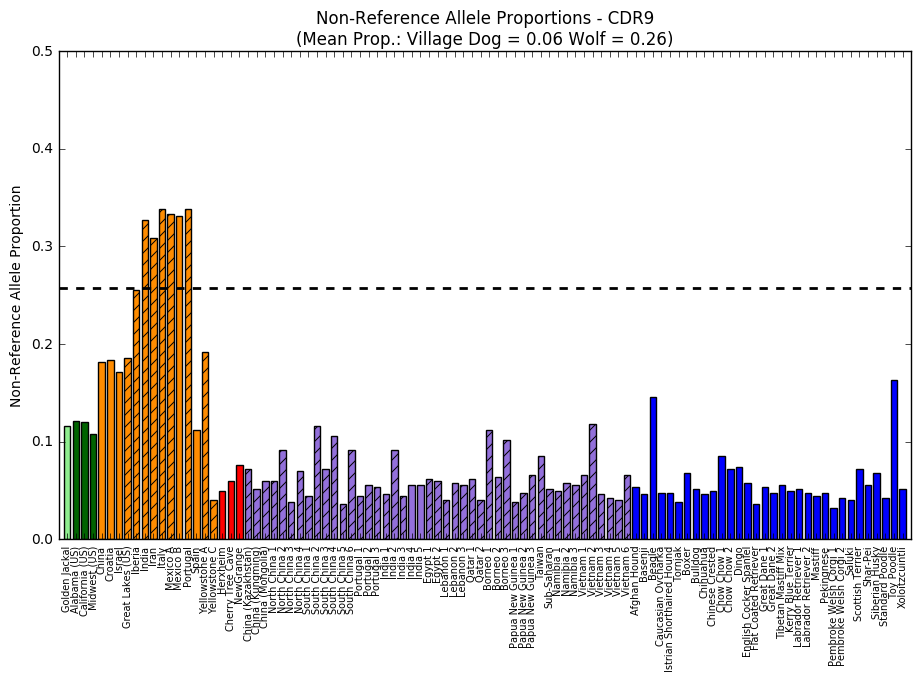

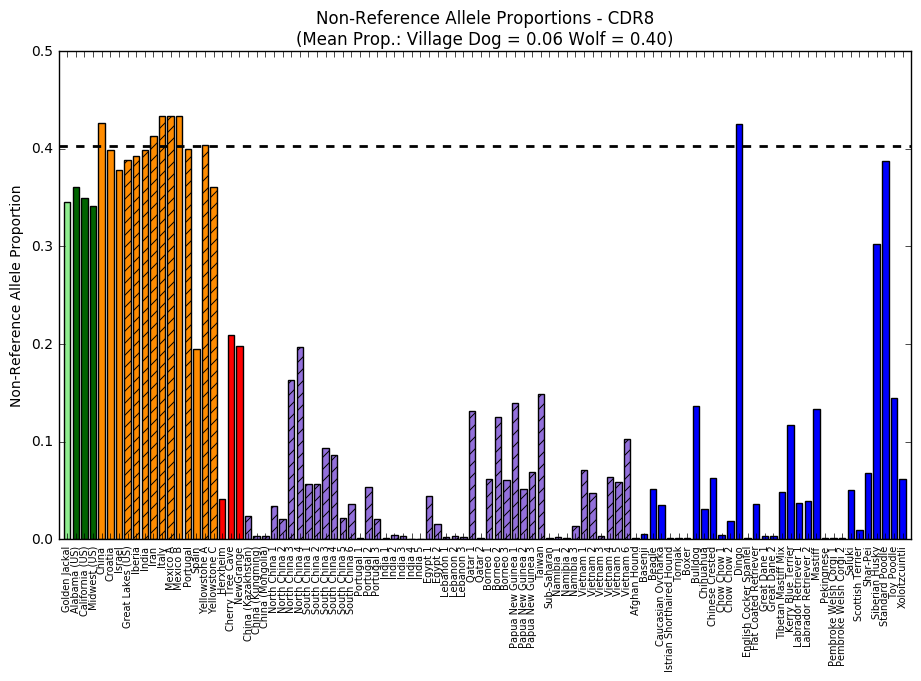

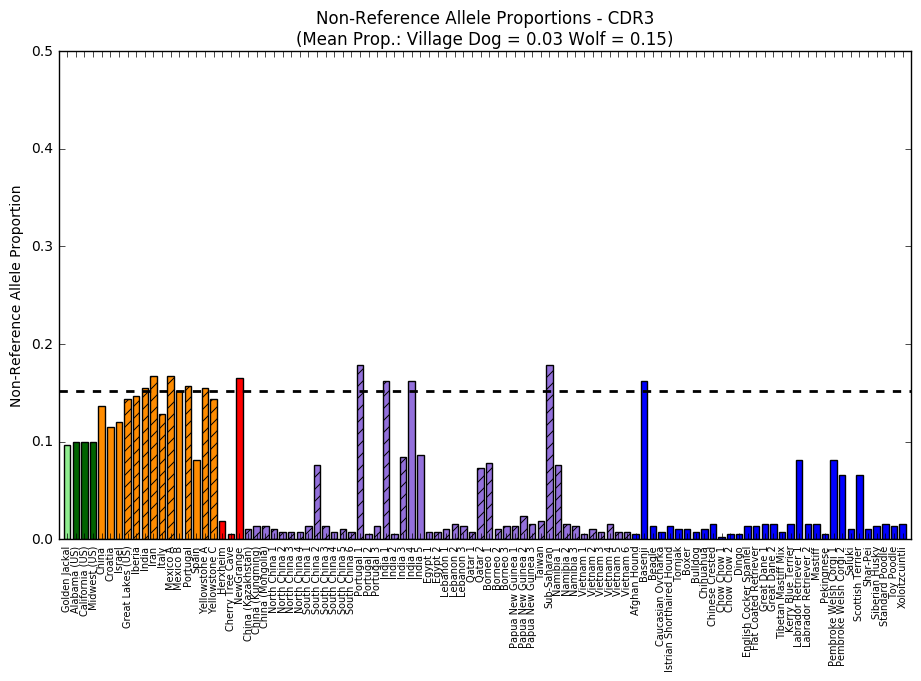

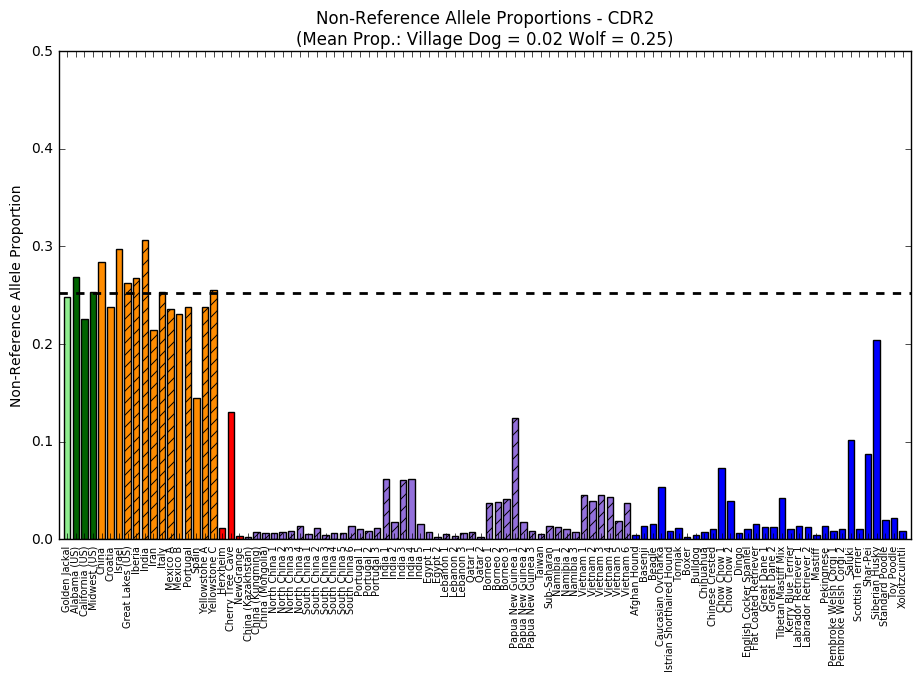

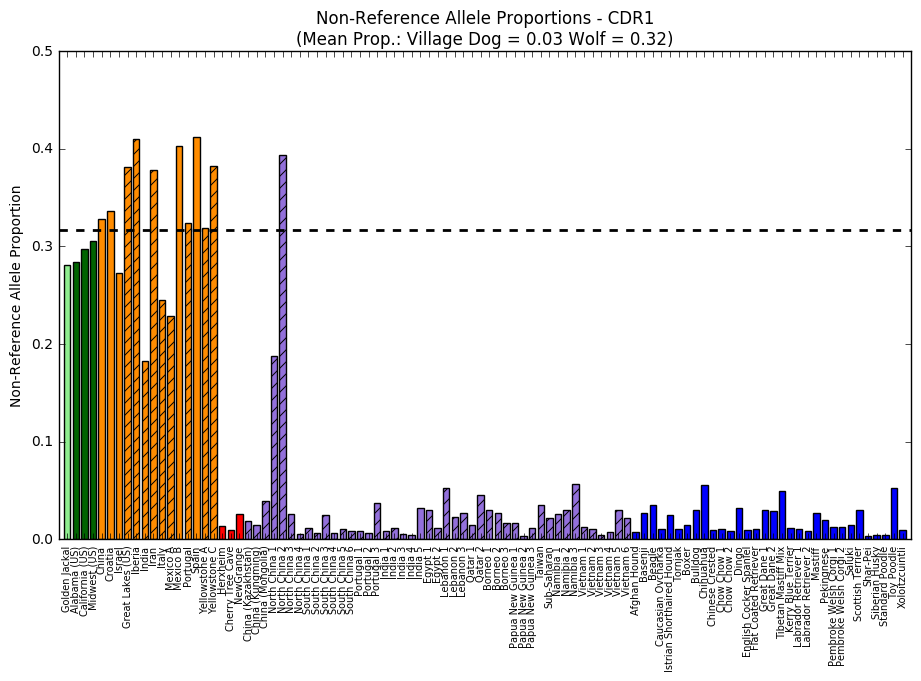

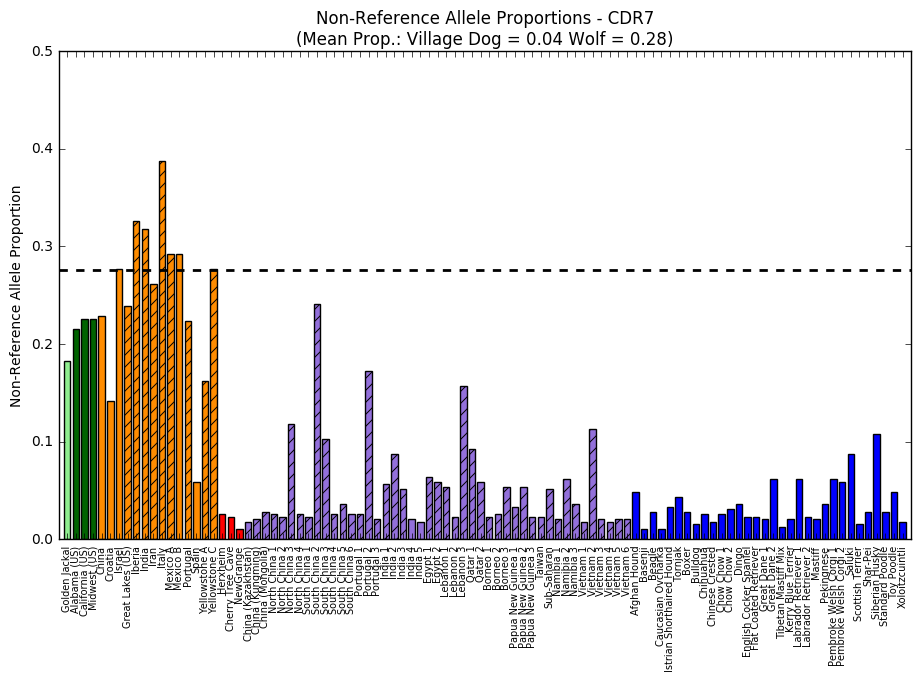

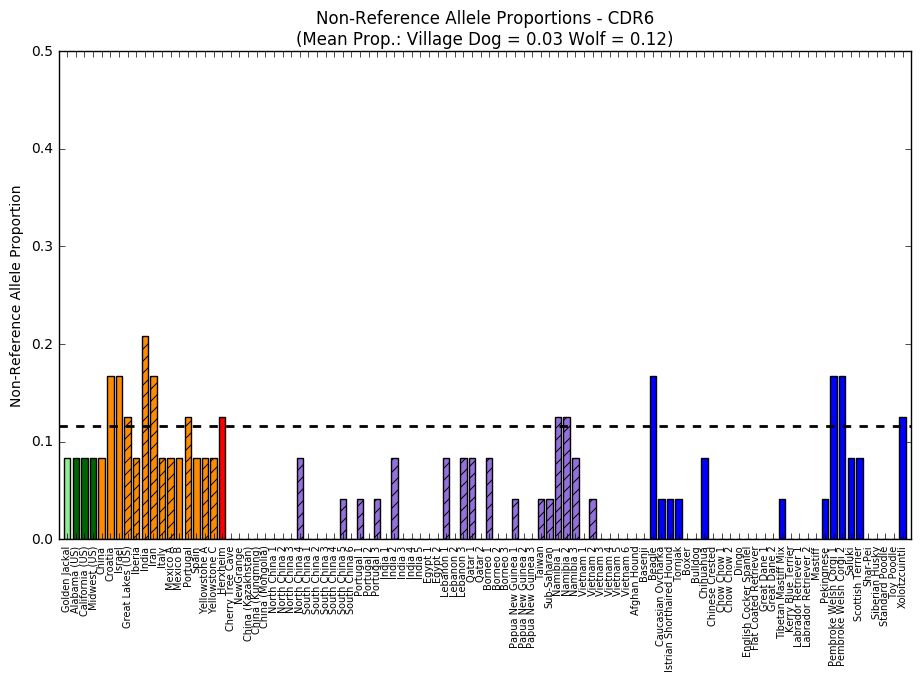

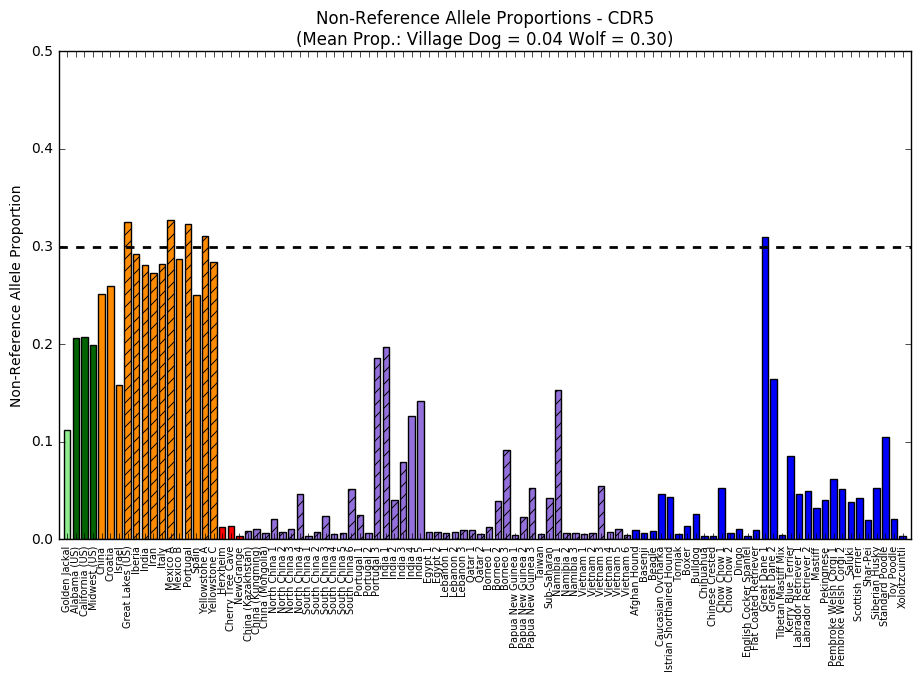

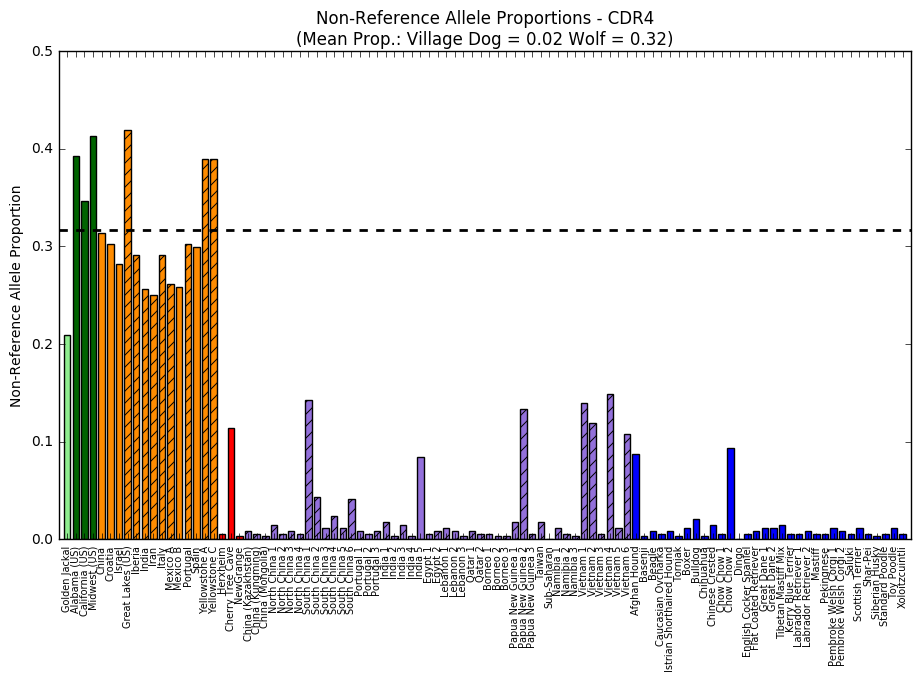

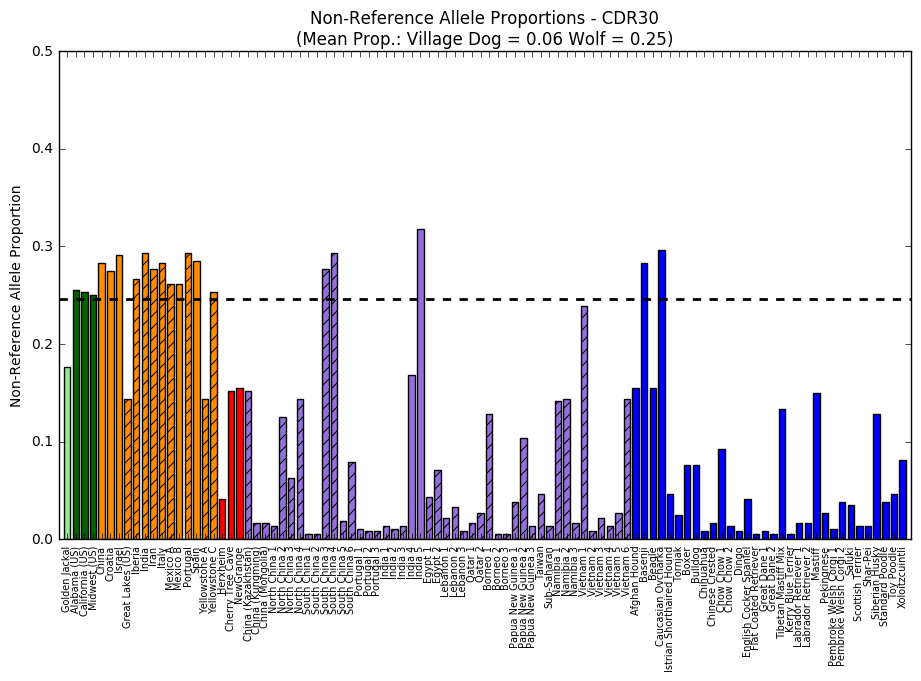

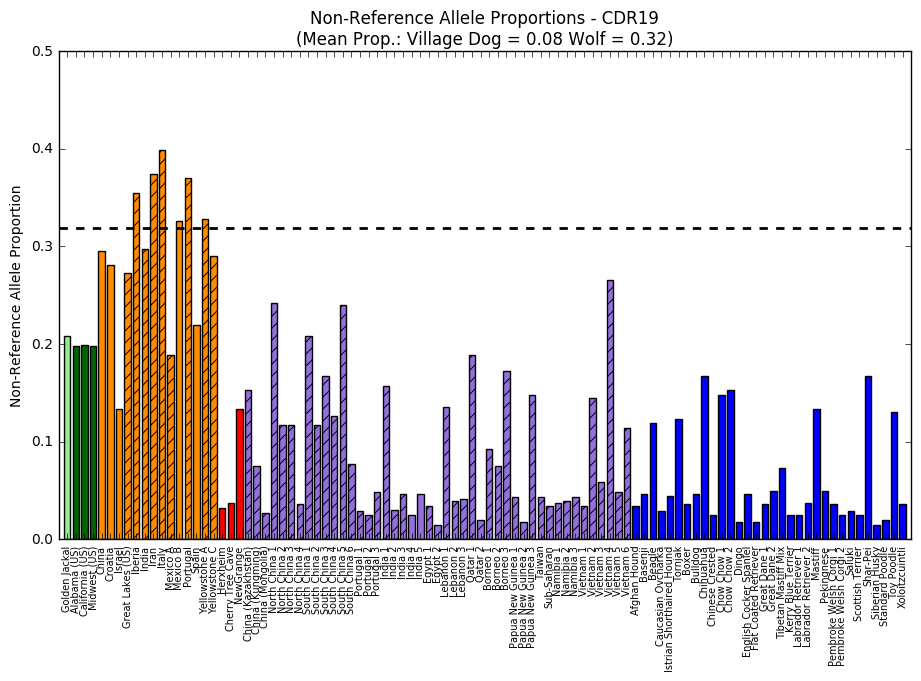

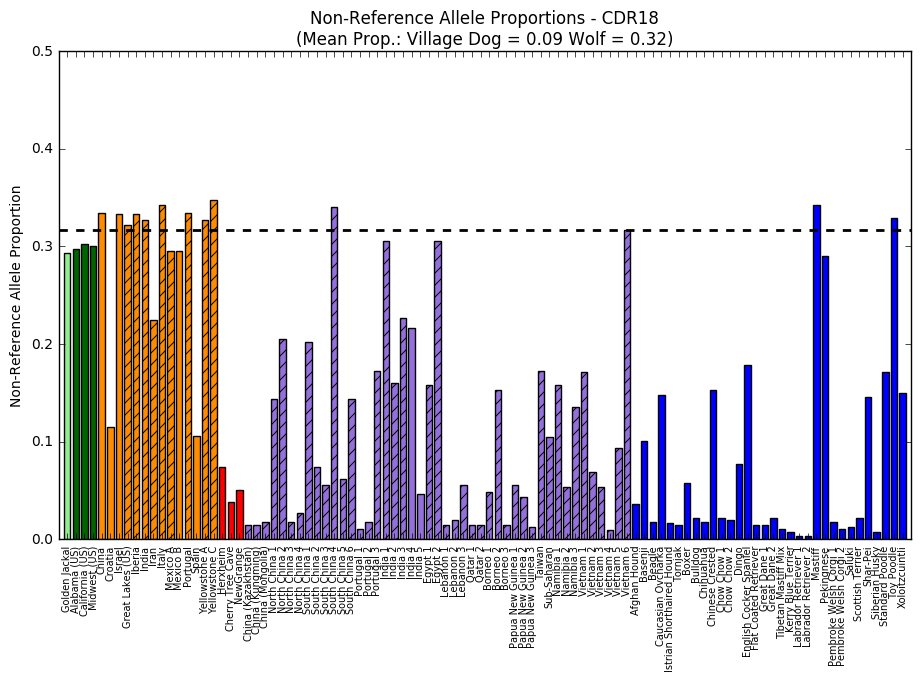

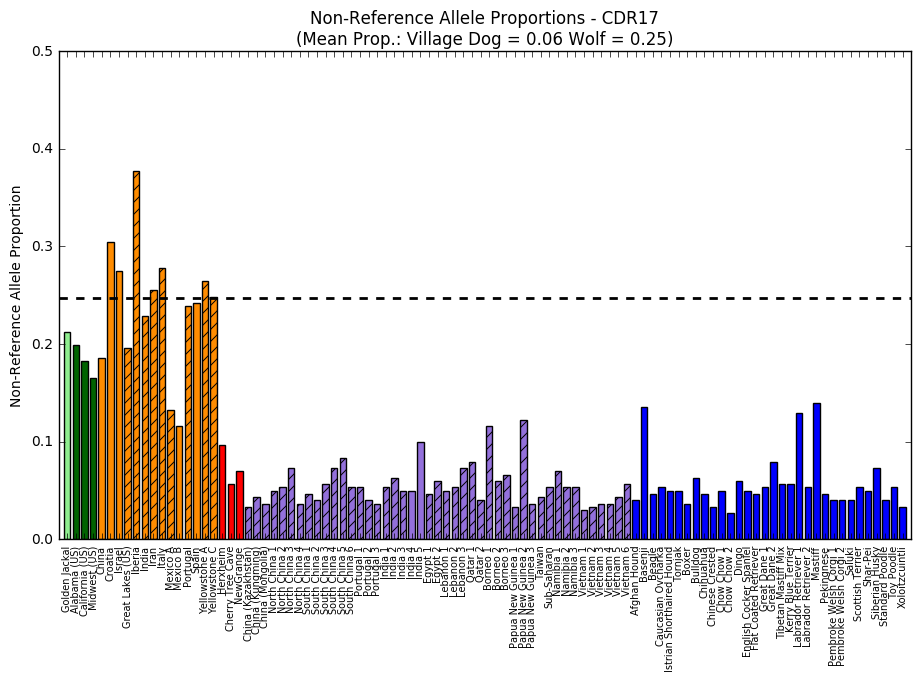

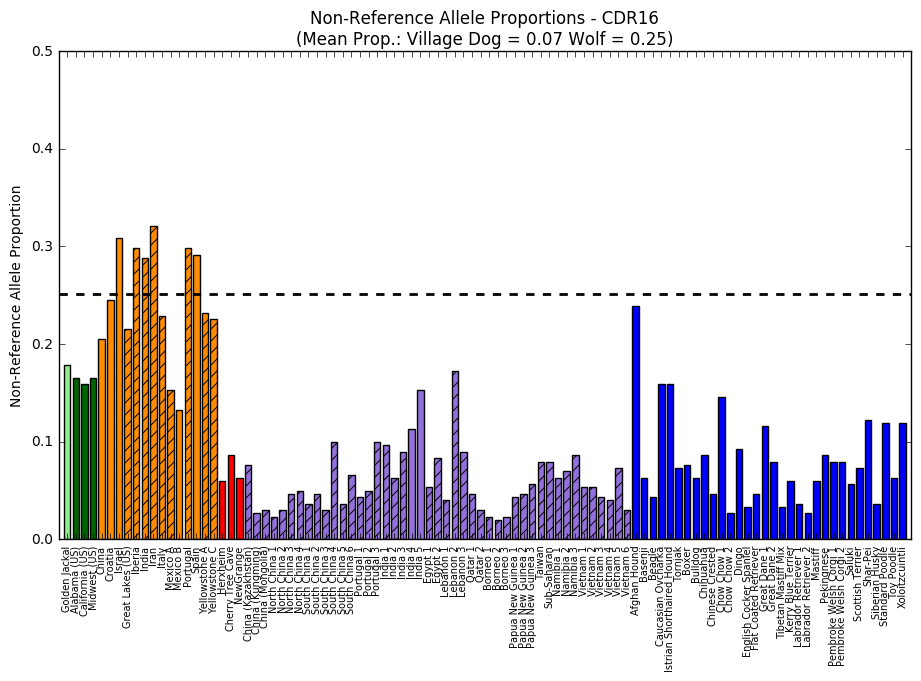

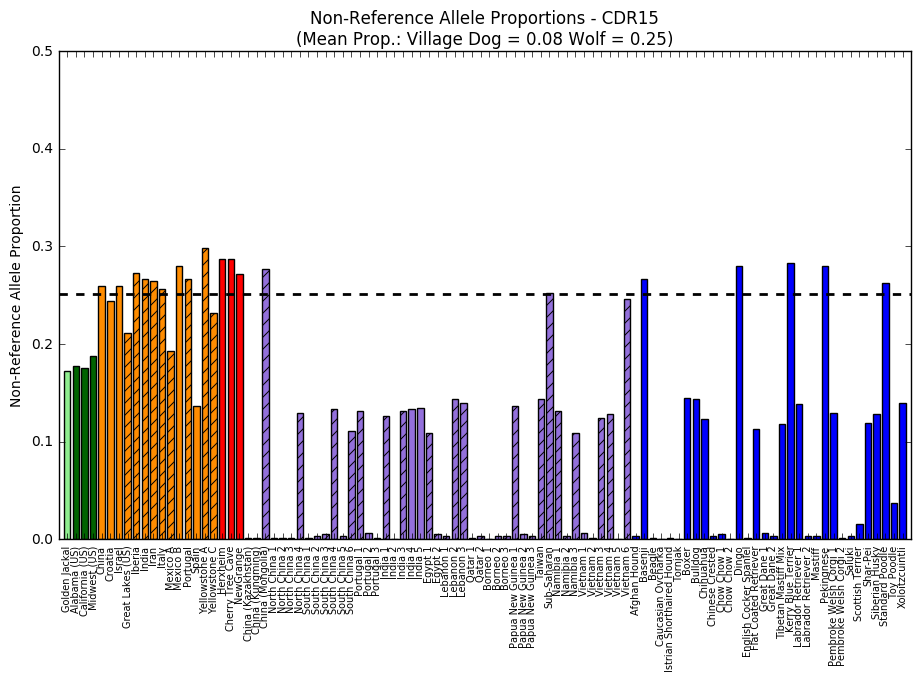

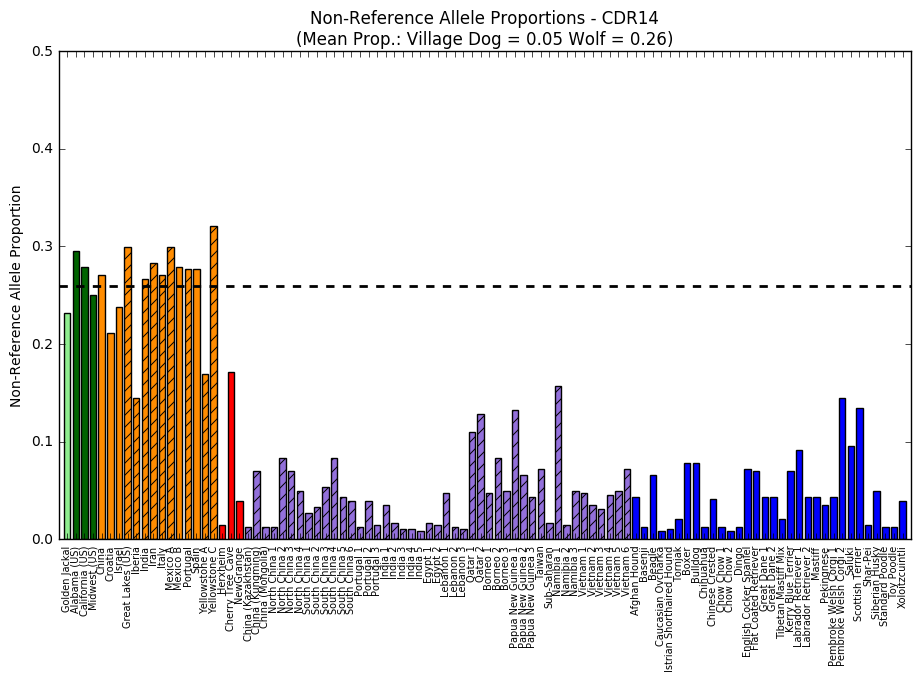

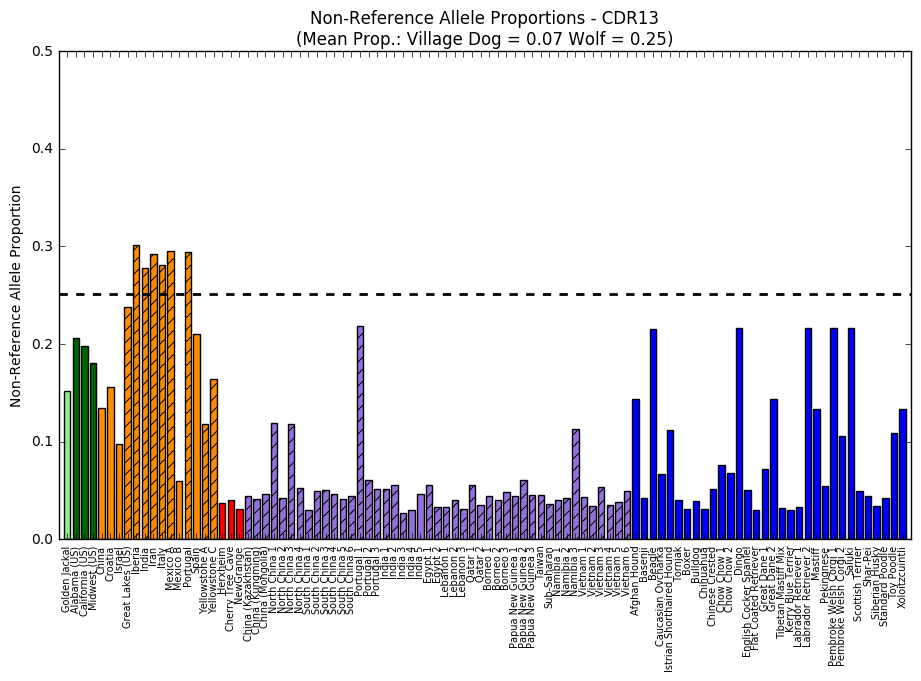

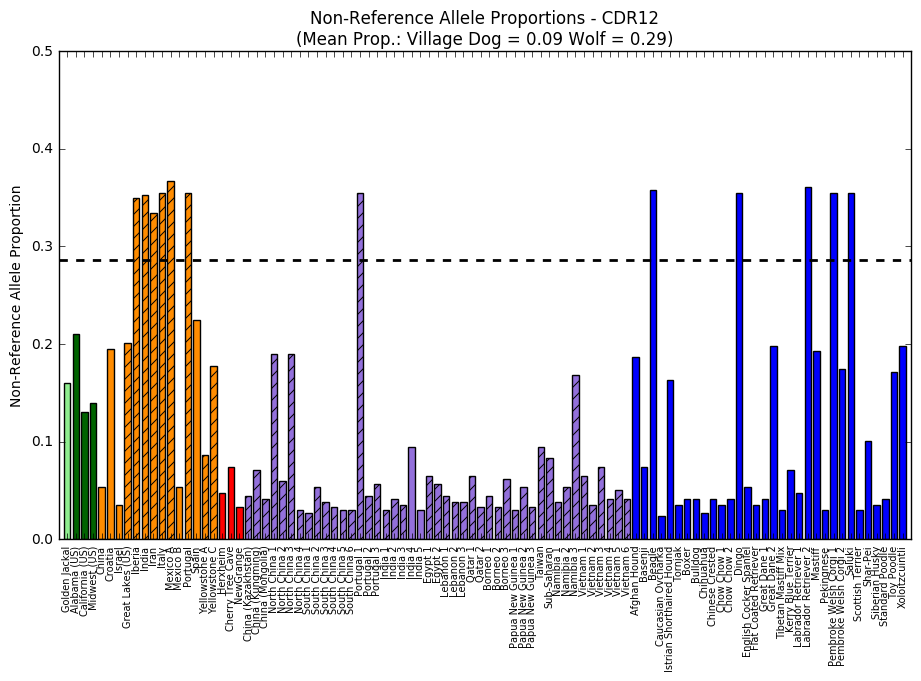

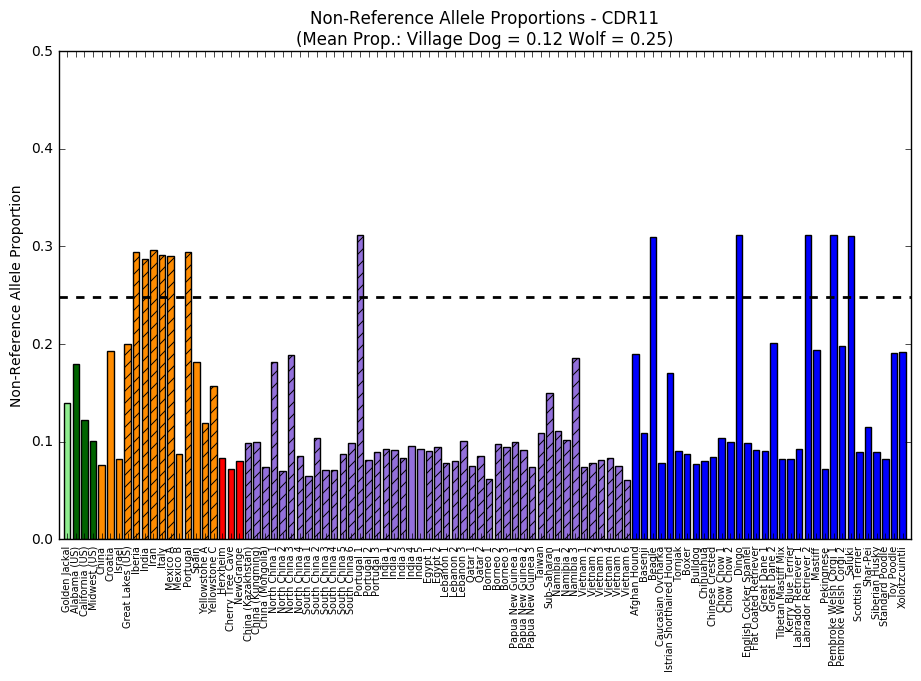

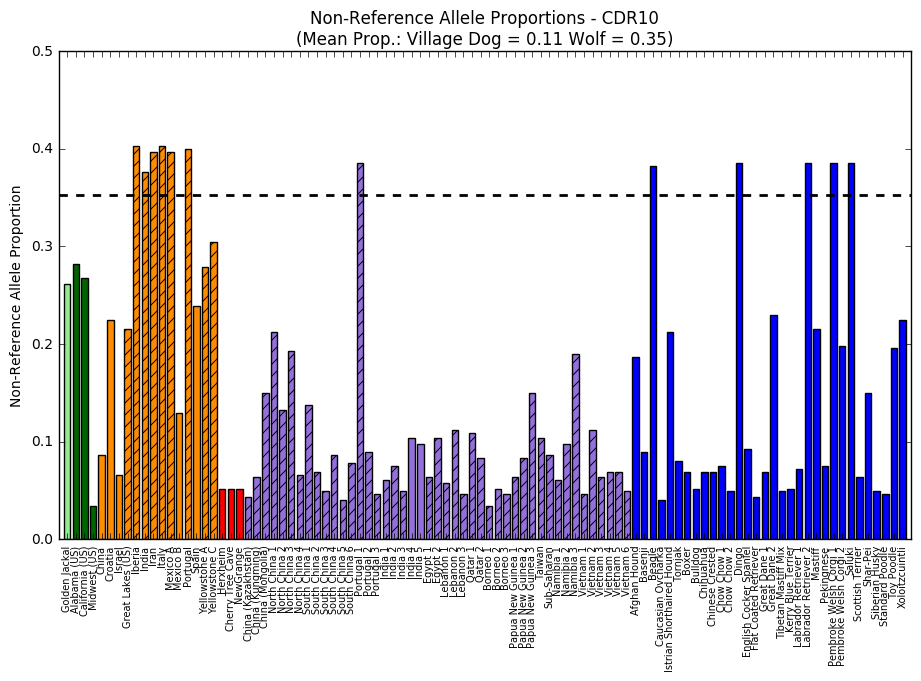

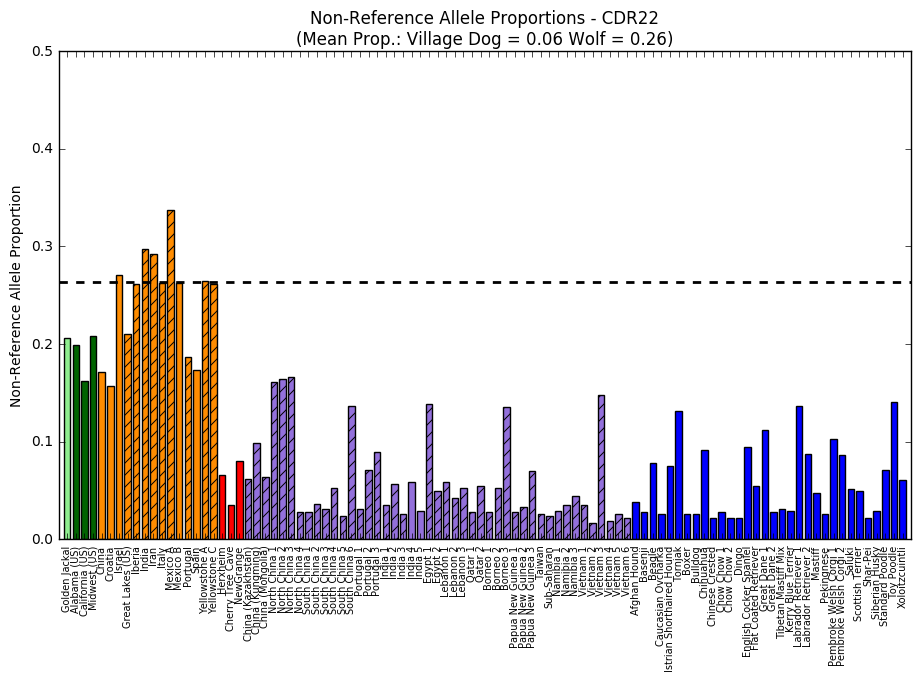

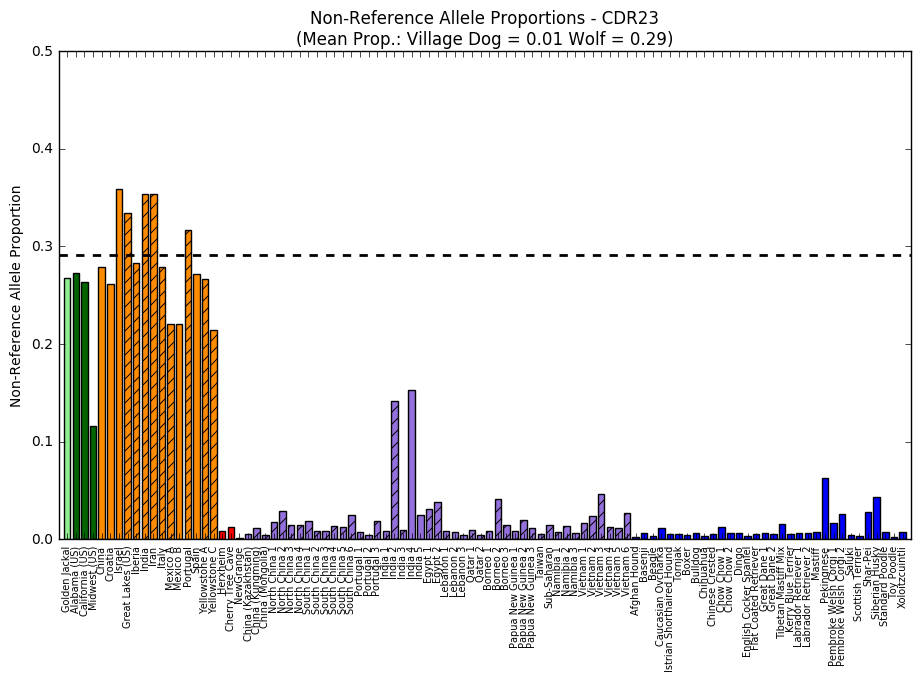

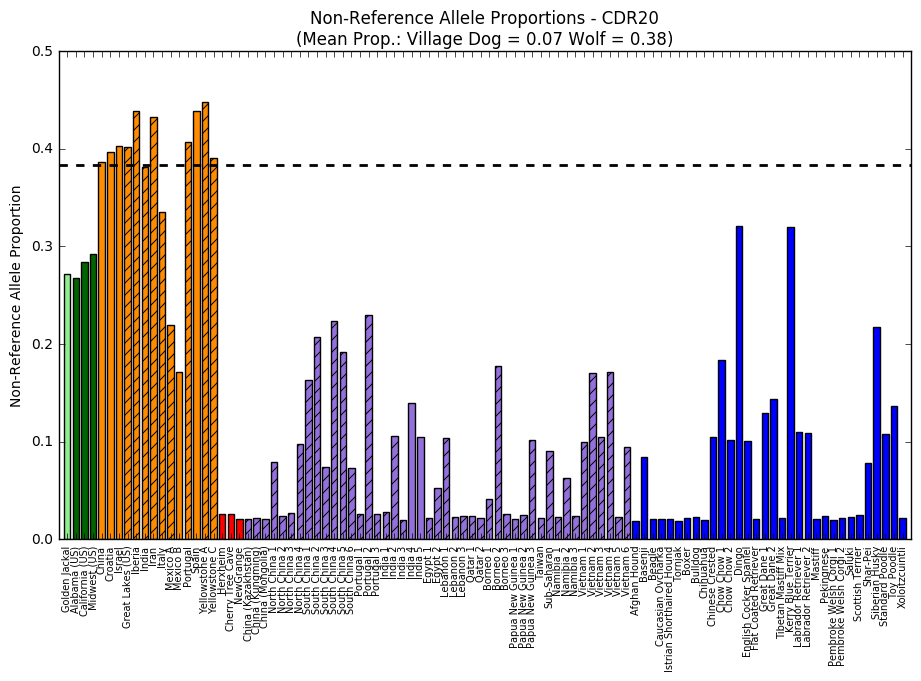

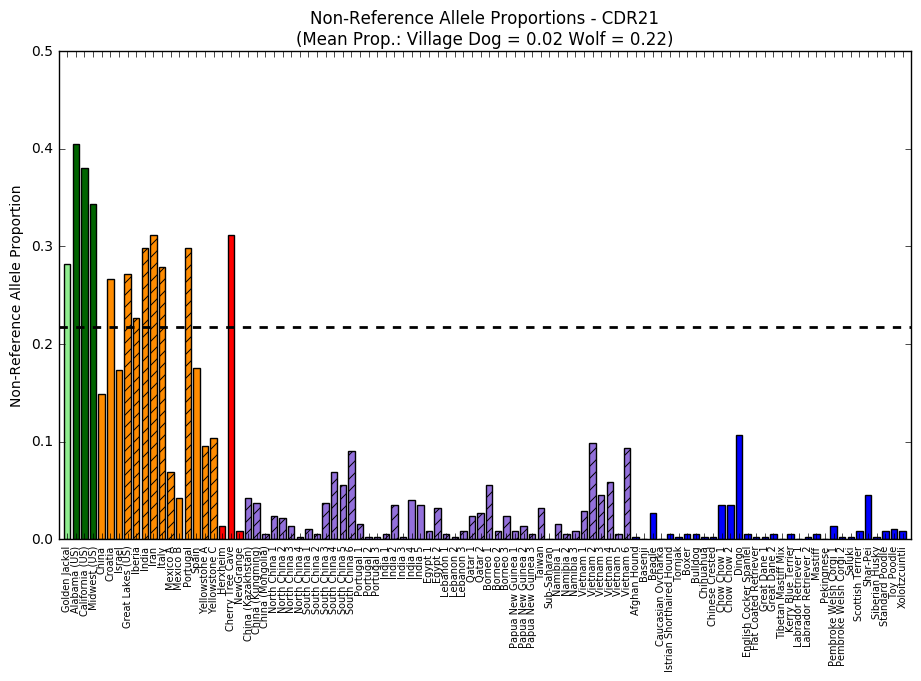

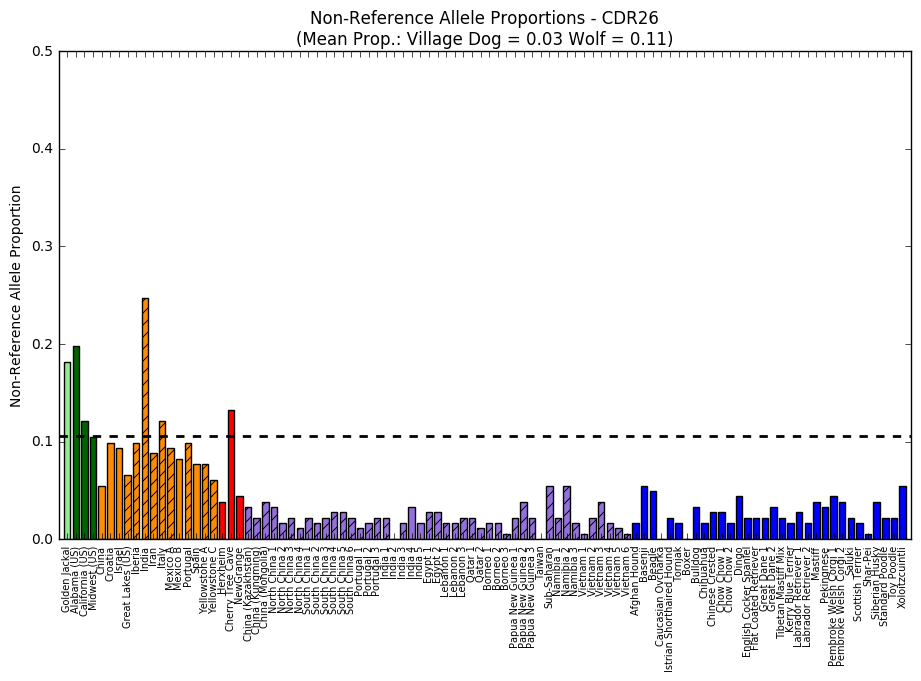

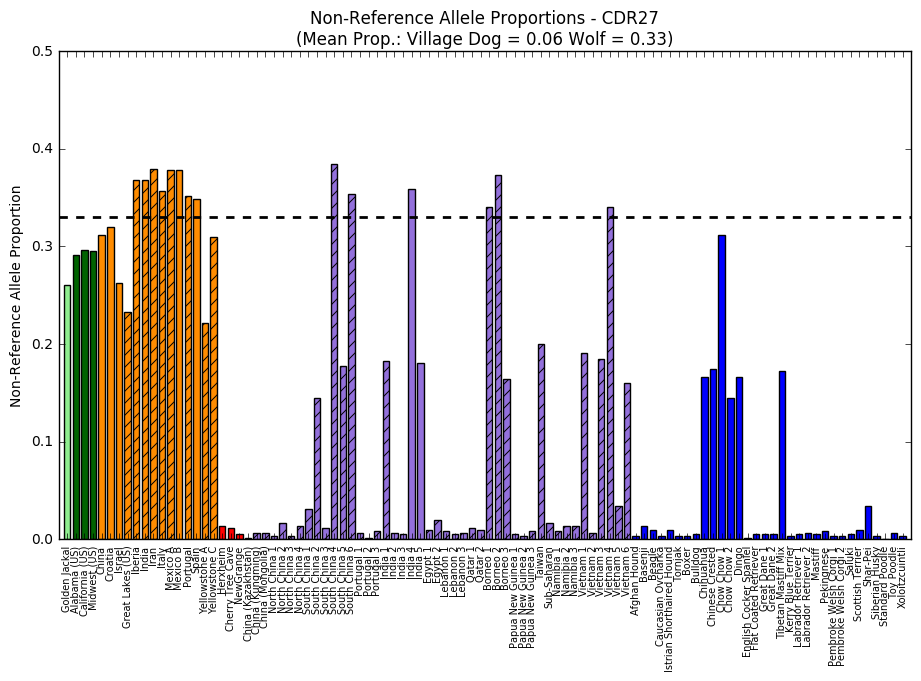

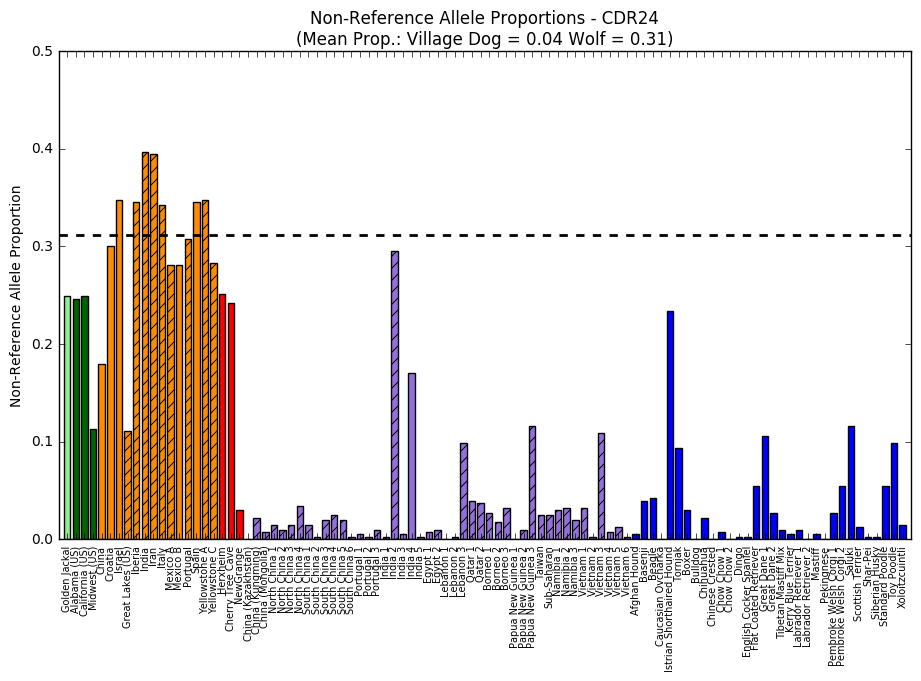

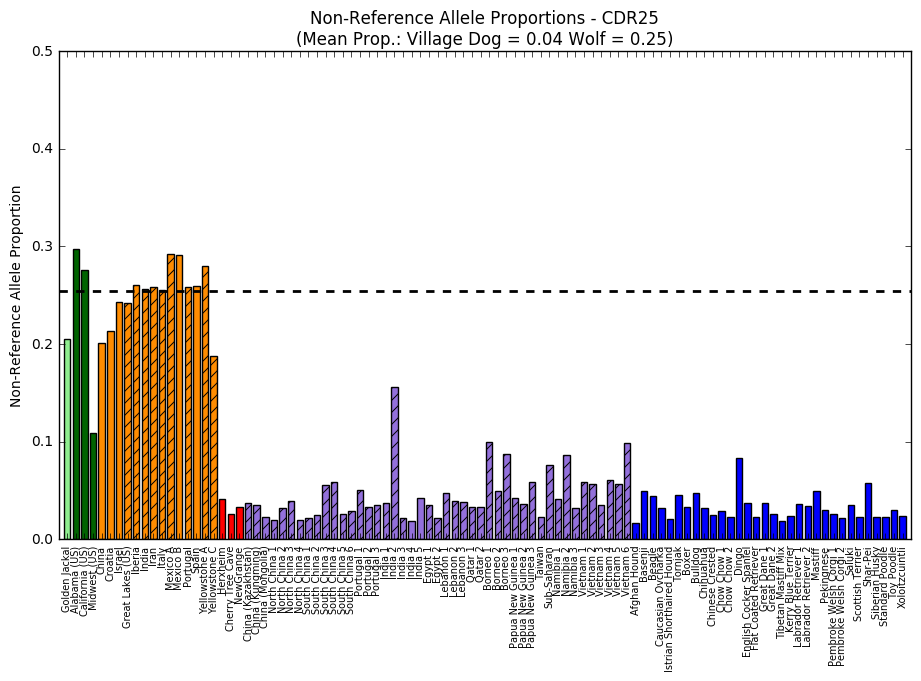

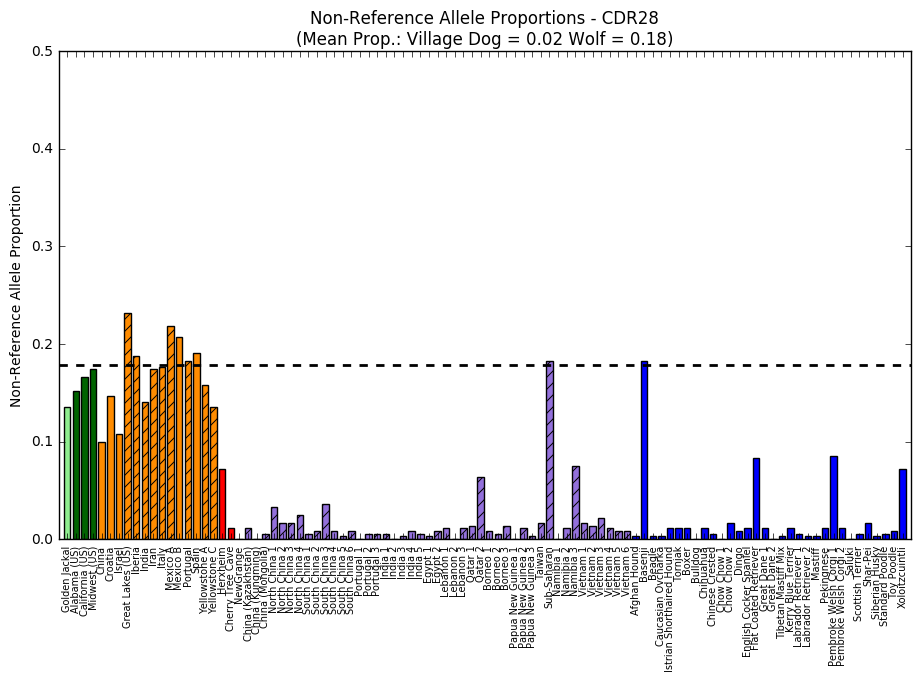

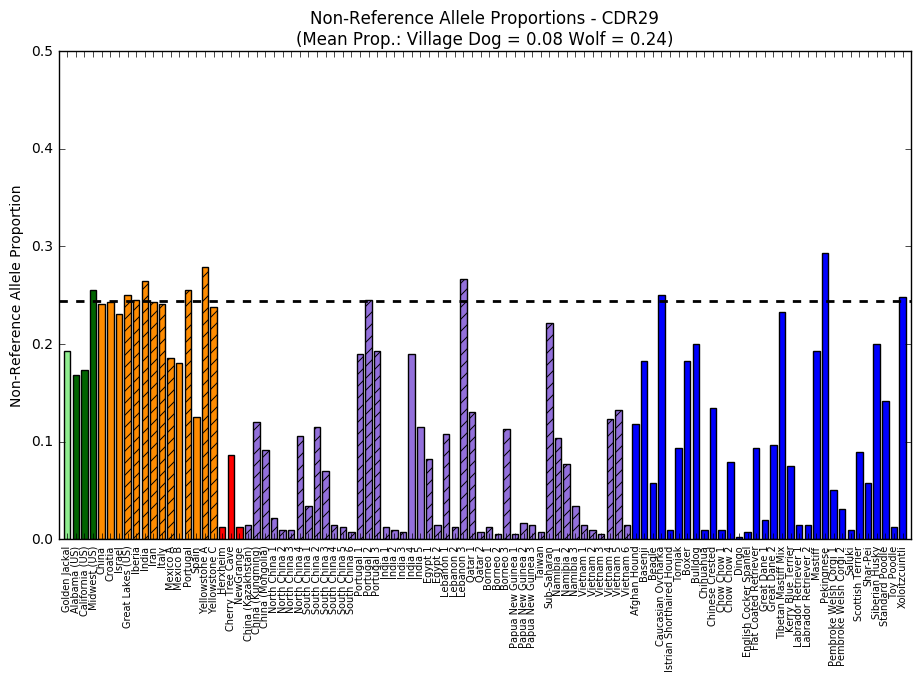

In [22]:
for CDR in propData:
    data = {}
    wolfMean = []
    for i in range(0,len(propData[CDR])):
        dog = dogs[i]
        data[dog] = [propData[CDR][i]]
    print CDR
    #PLOTTING
    labelFont  = {'fontname':'Arial'}
    width = .75
    #CLEARING OUT VARIABLES
    names, ticks, labels = [], [], {}
    labels['Fox']  =1 
    plt.figure(figsize=(11,7))
    #For keeping track of ymax
    Ymax = []
    for i in range(len(RDplotOrder)):
        canineType = RDplotOrder[i][2]
        sample = RDplotOrder[i][0]
        if canineType == 'Fox':
            color = 'lightgreen'
        elif canineType == 'Jackal':
            color = 'lightgreen'
        elif canineType == 'Coyote':
            color = 'darkgreen'
        elif canineType == 'Wolf':
            color = 'darkorange'
        elif canineType == 'AncientDog':
            color = 'red'
        elif canineType == 'Village Dog':
            color = 'mediumpurple'
        elif canineType == 'Breed':
            color = 'blue'
        elif canineType == 'New Guinea Singing Dog':
            color = 'steelblue'
        else:
            color = 'mediumpurple'
        if canineType in labels:
            if sample in fstDogs:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color, hatch = '//')
            else:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color)
        else:
            l = RDplotOrder[i][2]
            labels[l] = 1
            if l == 'Jackal':
                l = 'Fox and Jackal'
            if l == 'AncientDog':
                l = 'Ancient Dog'
            if l == 'VillageDog':
                l = 'Village Dog'
            if sample in fstDogs:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color, hatch = '//')
            else:
                _ = plt.bar(i,(1-get_ref_prop(RDplotOrder[i][0],data)),width,align='center',color=color)
            
            #_ = plt.bar(i,get_ref_prop(RDplotOrder[i][0],data),width,align='center',color=color,label=l)
        #Add the Ymax to the array 
        Ymax.append((1-get_ref_prop(RDplotOrder[i][0],data)))
        names.append(RDplotOrder[i][4])
        ticks.append(i)
                           
    _ =plt.xticks(ticks,names,rotation=90,fontsize=7)
    _ = plt.xlim([-1,ticks[-1]+1])
    _ = plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    #_ = plt.ylim([0,(max(Ymax)+.1)])
    _ = plt.ylim([0,0.5])

    plt.legend(loc=2)
    
    #Calculate average wolf non-ref 
    plt.axhline(y=CDRAverages[CDR][1],color='black',linestyle='--',linewidth=2)
                           
    #ADDING LABELS TO AXES AND TITLE TO PLOT
    plt.ylabel('Non-Reference Allele Proportion')
    dogProp = "{0:.2f}".format(round(CDRAverages[CDR][2],3))
    wolfProp = "{0:.2f}".format(round(CDRAverages[CDR][1],3))
    plt.title('Non-Reference Allele Proportions - %s\n(Mean Prop.: Village Dog = %s Wolf = %s)' % (CDR,dogProp,wolfProp))

    #MAKING LEGEND AT BOTTOM OF PlOT
    ax = plt.subplot(111)
    x = np.arange(10)
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5),fancybox=True, shadow=True, ncol=6)
    #GENERATING PLOT
    #plt.tight_layout()
    plt.savefig(directory + CDR + '_NonReferenceAllelePlot_shaded.png')

    